welcome to Lab 2 cowboy

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pymatgen import Composition
import sklearn
from functools import partial

# Supress unsightly warnings
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

orig_data = pd.read_csv("data.csv", na_filter=False)

### Q1 - Exploratory Data Analysis
#### Q1.1: How many elements are there in this data set?

In [2]:
orig_data['comp'] = orig_data['formula'].apply(lambda c: Composition(c))

In [3]:
element_lists = orig_data['comp'].apply(lambda c: c.elements)
element_popularity = element_lists.explode().value_counts()
print("There are", len(element_popularity), "elements in this dataset")

There are 89 elements in this dataset


#### Q1.2: What is the maximum number of elements (max_el) in a single structure?

In [4]:
element_count = orig_data['comp'].apply(lambda l: len(l))
max_els = max(element_count)

In [5]:
print("The max number of elements in a single structure is", max_els)

The max number of elements in a single structure is 9


#### Q1.3: Plot a barplot of the number of materials having 1, 2, 3, ... max_els.

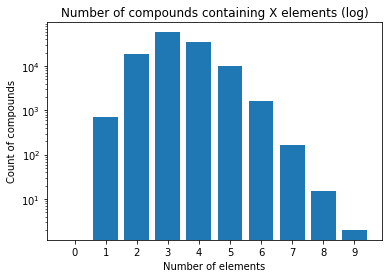

In [6]:
bins=np.arange(11) - 0.5
plt.hist(element_count, bins, log=True, rwidth=0.8)
plt.xticks(range(10))
plt.xlabel("Number of elements")
plt.ylabel("Count of compounds")
plt.title("Number of compounds containing X elements (log)")
plt.show()

#### Q1.4: What are the 10 most common elements in this data set? and what are the 10 least common elements in this data set?

In [7]:
element_popularity.sort_values(ascending=False)
print("10 most common elements:")
element_popularity[0:10]

10 most common elements:


O     60428
Li    18580
P     13321
Mn    11233
S     10516
Fe    10109
N      9723
F      9606
Si     8940
Mg     8711
Name: comp, dtype: int64

In [8]:
print("10 Least Common Elements:")
element_popularity[79:89]

10 Least Common Elements:


Pm    515
Pu    388
Np    340
Ac    297
Pa    253
Xe    147
Kr     15
He      8
Ar      2
Ne      1
Name: comp, dtype: int64

### Q2
#### Q2.1: Filter out materials that contain noble gas elements and save it in variable data. How many materials are left? 

In [9]:
orig_data['noble_gas'] = [i.contains_element_type('noble_gas') for i in orig_data['comp']]
noble_gases = orig_data[orig_data['noble_gas']]
data = orig_data[orig_data['noble_gas'] == False]
n = len(data)
print('There are', n, 'materials left.')
print('There were originally', n + len(noble_gases), 'materials.')

There are 124342 materials left.
There were originally 124515 materials.


#### Q2.2: Load the element property data file element_properties.csv. How many NaN (Not a Number) are there in each column?

In [10]:
element_data = pd.read_csv("element_properties.csv", index_col=0)
element_data.isna().sum()

AtomicRadius               7
AtomicVolume               2
AtomicWeight               0
BulkModulus               26
BoilingT                   2
Column                     0
CovalentRadius             0
Density                    2
ElectronAffinity           9
Electronegativity          4
FirstIonizationEnergy      1
HeatCapacityMass          10
Row                        0
phi                       22
SecondIonizationEnergy    12
ShearModulus              34
dtype: int64

#### Q2.3: Compute the mean values for each column, ignoring the NaNs. For each column, fill the NaN with the mean value of that column.

In [11]:
element_data = element_data.fillna(element_data.mean())

#### Q2.4: Compute the composition-averaged AtomicRadius for all materials and store the results in variable atomic_radius.

In [12]:
element_data_dict = element_data.to_dict() #transfer dataframe to dictionary
radius_dict = element_data_dict['AtomicRadius']

def avg_radius(comp):
    sum_radius = 0
    num_atoms = 0
    for ele, num in comp.items():
        sum_radius += (num*radius_dict[str(ele)])
        num_atoms += num
    return sum_radius/num_atoms

atomic_radius = orig_data['comp'].apply(avg_radius) 

#### Q2.5: Compute the composition-averaged properties for all properties in element_data and for all materials. 

In [13]:
# define a generic version of the above avg_radius function
def get_avg_prop(prop, comp):
    sum_prop = 0
    num_atoms = 0
    for ele, num in comp.items():
        sum_prop += (num*element_data_dict[prop][str(ele)])
        num_atoms += num
    return sum_prop/num_atoms

In [14]:
average_properties = pd.DataFrame()
for prop in element_data.columns:
    get_specific_avg_prop = partial(get_avg_prop, prop) #define a property-specific averaging function
    average = data['comp'].apply(get_specific_avg_prop) #apply the above function
    average_properties[("average_" + prop)] = average #add results to dataframe

print('Average properties dimension:', average_properties.shape)

Average properties dimension: (124342, 16)


#### Q2.6: Compute the maximum properties and minimum properties for all properties and all materials.

In [15]:
def get_max_prop(prop, comp):
    max_prop = None
    for ele, num in comp.items():
        prop_value = element_data_dict[prop][str(ele)]
        if max_prop:
            max_prop = prop_value if prop_value > max_prop else max_prop
        else:
            max_prop = prop_value
    return max_prop

In [16]:
max_properties = pd.DataFrame()
for prop in element_data.columns:
    get_specific_max_prop = partial(get_max_prop, prop) #define a property-specific max finding function
    maximum = data['comp'].apply(get_specific_max_prop) #apply the above function
    max_properties[("max_" + prop)] = maximum #add results to dataframe

In [17]:
def get_min_prop(prop, comp):
    min_prop = None
    for ele, num in comp.items():
        prop_value = element_data_dict[prop][str(ele)]
        if min_prop:
            min_prop = prop_value if prop_value < min_prop else min_prop
        else:
            min_prop = prop_value
    return min_prop

In [18]:
min_properties = pd.DataFrame()
for prop in element_data.columns:
    get_specific_min_prop = partial(get_min_prop, prop) #define a property-specific max finding function
    minimum = data['comp'].apply(get_specific_min_prop) #apply the above function
    min_properties[("min_" + prop)] = minimum #add results to dataframe

In [19]:
print('Max properties dimension:', max_properties.shape)
print('Min properties dimension:', min_properties.shape)

Max properties dimension: (124342, 16)
Min properties dimension: (124342, 16)


In [20]:
design_matrix = pd.concat([average_properties, max_properties, min_properties], axis = 1)

In [21]:
print('Design matrix properties dimension:', design_matrix.shape)

Design matrix properties dimension: (124342, 48)


### Q3

#### Q3.1: Split design matrix into training and test data

In [22]:
from sklearn.model_selection import train_test_split

targets = ['band_gap', 'formation_energy_per_atom', 'e_above_hull']
X = design_matrix
y = data[targets]
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.1, random_state=42)

#### Q3.2: Normalize the data

In [23]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(train_X)
means_ = scaler.mean_
stds_ = scaler.scale_
norm_train_X = scaler.transform(train_X)
norm_test_X = scaler.transform(test_X)

#### Q3.3: Use a linear model to predict formation energy. What are the test MAE and RMSE?

*Linear Regression*

In [24]:
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error, mean_squared_error

linreg = linear_model.LinearRegression()
linreg.fit(norm_train_X, train_y['formation_energy_per_atom'])
yhat = linreg.predict(norm_test_X)

mae = mean_absolute_error(test_y['formation_energy_per_atom'], yhat)
rmse = np.sqrt(mean_squared_error(test_y['formation_energy_per_atom'], yhat))
print('Linear Regression stats')
print('rmse: ', round(rmse,3), 'mae:', round(mae,3))

Linear Regression stats
rmse:  0.579 mae: 0.397


#### Q3.4: Now use RIDGE and LASSO models to predict formation energy. What are the test MAE and RMSE?

*RIDGE Regression*

In [25]:
ridge = linear_model.Ridge(alpha=0.1, max_iter=10000)
ridge.fit(norm_train_X, train_y['formation_energy_per_atom'])

prediction = ridge.predict(norm_test_X)

mae = mean_absolute_error(test_y['formation_energy_per_atom'],prediction)
rmse = np.sqrt(mean_squared_error(test_y['formation_energy_per_atom'],prediction))
print('RIDGE Regression stats')
print('rmse: ', round(rmse,3), 'mae:', round(mae,3))

RIDGE Regression stats
rmse:  0.579 mae: 0.397


*LASSO Regression*

In [26]:
lasso = linear_model.Lasso(alpha=0.1, max_iter=10000)
lasso.fit(norm_train_X, train_y['formation_energy_per_atom'])
prediction = lasso.predict(norm_test_X)

mae = mean_absolute_error(test_y['formation_energy_per_atom'],prediction)
rmse = np.sqrt(mean_squared_error(test_y['formation_energy_per_atom'],prediction))
print('LASSO Regression Stats')
print('rmse: ', round(rmse,3), 'mae:', round(mae,3))

LASSO Regression Stats
rmse:  0.669 mae: 0.466


#### Q3.5: Use LDA, QDA, and Logistic Regression models to classify materials as 'metallic' or 'nonmetallic'. 

In [27]:
classify = lambda x: 1 if x>=0.001 else 0
train_y = pd.DataFrame(train_y)
train_y['class'] = train_y['band_gap'].apply(classify)
test_y['class'] = test_y['band_gap'].apply(classify)

/home/robert/miniconda3/envs/nano281/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [28]:
from scipy import linalg
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
model = lda.fit(norm_train_X, train_y['class'])
ypred_lda = model.predict(norm_test_X)
score = model.score(norm_test_X, test_y['class'])

print('Predicted model accuracy is', round(score, 3))

Predicted model accuracy is 0.787


In [29]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

qda = QuadraticDiscriminantAnalysis(store_covariance=True)
model = qda.fit(norm_train_X, train_y['class'])
y_pred = model.predict(norm_test_X)
score = model.score(norm_test_X, test_y['class'])

print('Predicted model accuracy is', round(score, 3))

Predicted model accuracy is 0.785


In [30]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(penalty='none', solver='lbfgs', max_iter=1000)
model = clf.fit(norm_train_X, train_y['class'])
y_pred = model.predict(norm_test_X)
score = model.score(norm_test_X, test_y['class'])

print('Predicted model accuracy is', round(score, 3))

Predicted model accuracy is 0.792


#### Q3.6: Discuss problems of using only compositions to predict material properties.

Using only compositions to predict material properties neglects the significant impact that a material's structure (e.g. lattice shape and symmetry) has on its properties. Material structure is not necessarily implied by the material's chemical composition (for materials with more than one stable form), so two materials with the same chemical composition could have different properties, but a model based on composition would predict that same properties for both.

### Q4
#### Q4.1: Read in the image as a numpy array using matplotlib. Show the image in your Jupyter notebook. What are the dimensions of the array?

The array dimensions are (200, 200)


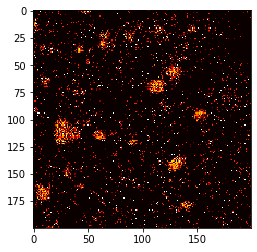

In [31]:
catalyst = plt.imread('catalyst.png', format='png')
a = plt.imshow(catalyst, cmap='hot')
print("The array dimensions are", catalyst.shape)

#### Q4.2: Plot the distribution of the values in the numpy array representing the image.

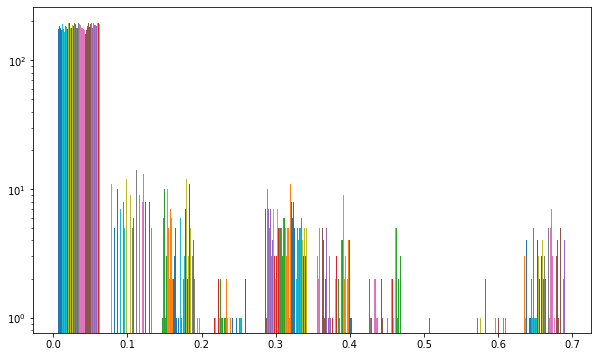

In [32]:
fig, ax = plt.subplots(figsize=(10, 6))
figure1 = ax.hist(catalyst, log=True)

#### Q4.3: Plot the quantized K-means image of catalyst

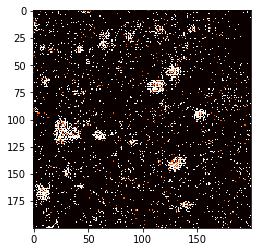

In [33]:
from sklearn.cluster import KMeans

flat_cat = catalyst.flatten()

clustering = KMeans(3).fit_predict(flat_cat.reshape(-1,1))
clustering = clustering.reshape(200,200)
_ = plt.imshow(clustering, cmap='hot')

#### Q4.4 Use k-means clustering to identify clusters of particles.

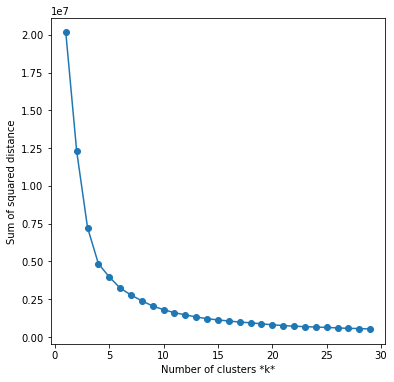

In [34]:
# Use the elbow method to determine the best value of k for k-means
inertias = []
test_ks = list(range(1, 30))

particles = np.array(np.nonzero(clustering)).transpose()

for k in test_ks:
    km = KMeans(n_clusters=k)
    km.fit(particles)
    inertias.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(test_ks, inertias, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

Text(0.5, 1.0, 'K = 20')

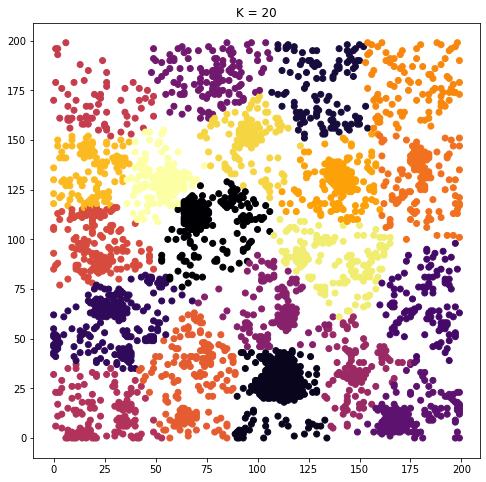

In [35]:
happy_cluster = KMeans(20).fit(particles)

fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(particles[:,0], particles[:,1], c=happy_cluster.labels_, cmap='inferno')
ax.set_title("K = 20")

#### Q4.5: Use DBSCAN clustering to identify clusters of particles

Using a different "elbow" method with K-nearest neighbors to determine the optimum value for epsilon in DBSCAN. The 'crook of the elbow' (point of maximum curvature) should indicate the best value for epsilon. Based on the method described in this paper https://iopscience.iop.org/article/10.1088/1755-1315/31/1/012012

Text(0.5, 1.0, 'K-distance elbow plot')

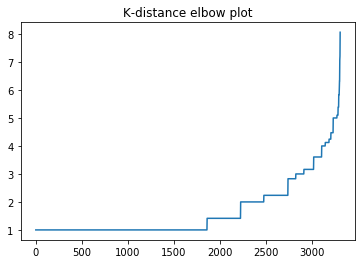

In [36]:
from sklearn.neighbors import NearestNeighbors

neighbors = NearestNeighbors(n_neighbors=20)
neighbors_fit = neighbors.fit(particles)
distances, indices = neighbors_fit.kneighbors(particles)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.title('K-distance elbow plot')

Crook of elbow appears to be between 2 and 3 - estimating 2.5.

Text(0.5, 1.0, 'eps = 2.5')

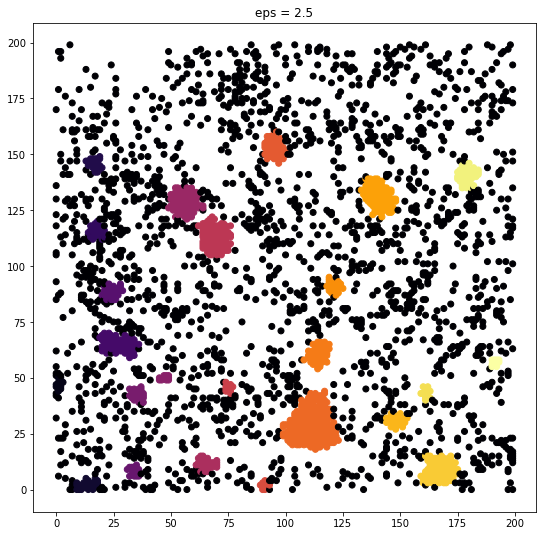

In [37]:
from sklearn.cluster import DBSCAN
fig, ax = plt.subplots(figsize=(9, 9))

db_cluster = DBSCAN(eps=2.5, min_samples=10).fit(particles) # as they say, 10 particles makes a cluster! ¯\_(ツ)_/¯ 
ax.scatter(particles[:,0], particles[:,1], c=db_cluster.labels_, cmap='inferno')
ax.set_title("eps = 2.5")

#### Q4.6: Discussion of results

Based on the visual difference between the K-means clustered plot and the DBSCAN clustered plot, it's clear that the DBSCAN cluster method is superior to K-means for detecting clusters of particles in the noisy data. The central task to identifying nanoparticle clusters amidst a sea of individual points is to detect and identify areas of high density, while ignoring areas of low density. DBSCAN does this well, and with a cutoff value of around 10, it picks up all of the groups that clearly appear to be particles while only highlighting a few "clusters" that look more like noise than cluster. On the other hand, it seems that K-means will identify exactly as many cluster as the value of K, including many regions on the graph that are obviously not dense enough to be clusters. K-means is just not suited to this application. 